In [50]:
import pandas as pd
import numpy as np
import sklearn.preprocessing as pr
import sklearn.linear_model as linear
import matplotlib.pyplot as plt
# import sklearn as sk

In [2]:
!head adult.data

39, State-gov, 77516, Bachelors, 13, Never-married, Adm-clerical, Not-in-family, White, Male, 2174, 0, 40, United-States, <=50K
50, Self-emp-not-inc, 83311, Bachelors, 13, Married-civ-spouse, Exec-managerial, Husband, White, Male, 0, 0, 13, United-States, <=50K
38, Private, 215646, HS-grad, 9, Divorced, Handlers-cleaners, Not-in-family, White, Male, 0, 0, 40, United-States, <=50K
53, Private, 234721, 11th, 7, Married-civ-spouse, Handlers-cleaners, Husband, Black, Male, 0, 0, 40, United-States, <=50K
28, Private, 338409, Bachelors, 13, Married-civ-spouse, Prof-specialty, Wife, Black, Female, 0, 0, 40, Cuba, <=50K
37, Private, 284582, Masters, 14, Married-civ-spouse, Exec-managerial, Wife, White, Female, 0, 0, 40, United-States, <=50K
49, Private, 160187, 9th, 5, Married-spouse-absent, Other-service, Not-in-family, Black, Female, 0, 0, 16, Jamaica, <=50K
52, Self-emp-not-inc, 209642, HS-grad, 9, Married-civ-spouse, Exec-managerial, Husband, White, Male, 0, 0, 45, United-States, >50K
31, 

In [3]:
!tail -n 14 adult.names

age: continuous.
workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
fnlwgt: continuous.
education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
education-num: continuous.
marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
sex: Female, Male.
capital-gain: continuous.
capital-loss: continuous.
hours-per-week: continuous.
native-country: United-States, Cambodia, England, Puerto-Ri

In [4]:
with open('adult.names') as file:
    rows = file.read().split('\n')[-15:]
    col_names = [row.split(':')[0] for row in rows][:-1] + ['label']

In [5]:
col_names

['age',
 'workclass',
 'fnlwgt',
 'education',
 'education-num',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'native-country',
 'label']

In [6]:
df = pd.read_csv('adult.data', header=None, names=col_names, skipinitialspace=True)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [7]:
y = df['label'] == '>50K'

In [8]:
x = df.drop(columns=['label', 'fnlwgt', 'sex'])
x_categorical = x.select_dtypes('object')
x_numerical = x.select_dtypes('int')

In [11]:
protected_label = df['sex'] == 'Female'

In [9]:
x_categorical

,workclass,education,marital-status,occupation,relationship,race,native-country
0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,United-States
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,United-States
2,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,United-States
3,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,United-States
4,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Cuba
...,...,...,...,...,...,...,...
32556,Private,Assoc-acdm,Married-civ-spouse,Tech-support,Wife,White,United-States
32557,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,United-States
32558,Private,HS-grad,Widowed,Adm-clerical,Unmarried,White,United-States
32559,Private,HS-grad,Never-married,Adm-clerical,Own-child,White,United-States


In [10]:
x_numerical

,age,education-num,capital-gain,capital-loss,hours-per-week
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40
3,53,7,0,0,40
4,28,13,0,0,40
...,...,...,...,...,...
32556,27,12,0,0,38
32557,40,9,0,0,40
32558,58,9,0,0,40
32559,22,9,0,0,20


In [14]:
enc = pre.OneHotEncoder(sparse=False)

In [15]:
x_one_hot = enc.fit_transform(x_categorical)

In [16]:
# enc.fit_transform(df.select_dtypes('object')).shape

In [17]:
enc.categories_

[array(['?', 'Federal-gov', 'Local-gov', 'Never-worked', 'Private',
        'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay'],
       dtype=object),
 array(['10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th',
        'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad',
        'Masters', 'Preschool', 'Prof-school', 'Some-college'],
       dtype=object),
 array(['Divorced', 'Married-AF-spouse', 'Married-civ-spouse',
        'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed'],
       dtype=object),
 array(['?', 'Adm-clerical', 'Armed-Forces', 'Craft-repair',
        'Exec-managerial', 'Farming-fishing', 'Handlers-cleaners',
        'Machine-op-inspct', 'Other-service', 'Priv-house-serv',
        'Prof-specialty', 'Protective-serv', 'Sales', 'Tech-support',
        'Transport-moving'], dtype=object),
 array(['Husband', 'Not-in-family', 'Other-relative', 'Own-child',
        'Unmarried', 'Wife'], dtype=object),
 array(['Amer-Indian-Eskimo'

In [18]:
cols = []
for main_category, sub_categories in zip(x_categorical.columns, enc.categories_):
    cols += [f'{main_category}_{sub}' for sub in sub_categories]

In [19]:
cols

['workclass_?',
 'workclass_Federal-gov',
 'workclass_Local-gov',
 'workclass_Never-worked',
 'workclass_Private',
 'workclass_Self-emp-inc',
 'workclass_Self-emp-not-inc',
 'workclass_State-gov',
 'workclass_Without-pay',
 'education_10th',
 'education_11th',
 'education_12th',
 'education_1st-4th',
 'education_5th-6th',
 'education_7th-8th',
 'education_9th',
 'education_Assoc-acdm',
 'education_Assoc-voc',
 'education_Bachelors',
 'education_Doctorate',
 'education_HS-grad',
 'education_Masters',
 'education_Preschool',
 'education_Prof-school',
 'education_Some-college',
 'marital-status_Divorced',
 'marital-status_Married-AF-spouse',
 'marital-status_Married-civ-spouse',
 'marital-status_Married-spouse-absent',
 'marital-status_Never-married',
 'marital-status_Separated',
 'marital-status_Widowed',
 'occupation_?',
 'occupation_Adm-clerical',
 'occupation_Armed-Forces',
 'occupation_Craft-repair',
 'occupation_Exec-managerial',
 'occupation_Farming-fishing',
 'occupation_Handlers-

In [20]:
x_enc = pd.DataFrame(data=x_one_hot, columns=cols)
x_post = pd.concat([x_numerical, x_enc], axis=1)

In [21]:
x_post

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,39,13,2174,0,40,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,50,13,0,0,13,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,38,9,0,0,40,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,53,7,0,0,40,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,28,13,0,0,40,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,12,0,0,38,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
32557,40,9,0,0,40,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
32558,58,9,0,0,40,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
32559,22,9,0,0,20,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [22]:
import sklearn.linear_model as linear

In [27]:
model = linear.LogisticRegression(penalty='none', max_iter=2000)
model.fit(x_post, y)

LogisticRegression(max_iter=2000, penalty='none')

In [34]:
probs = model.predict_proba(x_post)

In [31]:
model.score(x_post[protected_label], y[protected_label])

0.9258193296815523

In [32]:
model.score(x_post[~protected_label], y[~protected_label])

0.8147774208352455

In [33]:
import sklearn.metrics as metrics

In [42]:
fpr, tpr, thresholds = metrics.roc_curve(y, probs[:, 1])

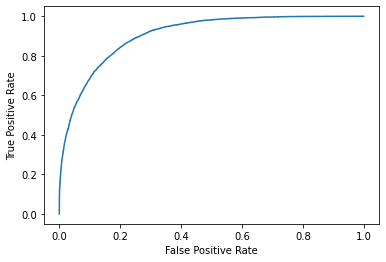

In [46]:
metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

/var/folders/nc/dhtws2m1317bwzbsxq9n3_gc0000gn/T/ipykernel_11392/2117704448.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


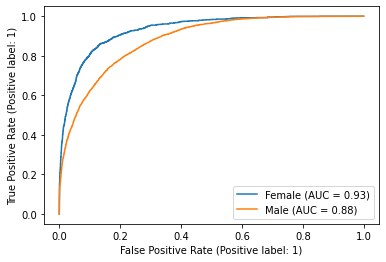

In [52]:
fig, ax = plt.subplots()

metrics.RocCurveDisplay.from_predictions(y[protected_label], probs[protected_label, 1], ax=ax, name='Female')
metrics.RocCurveDisplay.from_predictions(y[~protected_label], probs[~protected_label, 1], ax=ax, name='Male')
fig.show()